# Inference a model on a single image patch

In [1]:
import glob
from pathlib import Path

from mmseg.apis import init_model, inference_model

from monai.data import MetaTensor
from monai.metrics import DiceMetric

import cv2
import torch
import numpy as np
import random

import matplotlib.pyplot as plt
from skimage import color

## Helper functions

In [2]:
def calculate_dice(pred_mask: np.ndarray, gt_mask: np.ndarray):
    # pre-process data for DICE calculation
    gt_mask = torch.from_numpy(gt_mask/gt_mask.max())
    gt_mask = MetaTensor(gt_mask)
    gt_mask = [gt_mask.unsqueeze(0)]

    pred_mask = torch.from_numpy(pred_mask)
    pred_mask = MetaTensor(pred_mask)
    pred_mask = [pred_mask.unsqueeze(0)]
    
    dice_metric = DiceMetric(include_background=False, reduction="none", get_not_nans=False)
    dice_metric(y_pred=pred_mask, y=gt_mask)

    return dice_metric.aggregate().item()

def overlay(image: np.ndarray,
            mask: np.ndarray,
            alpha=0.5,
            bg_label=0, 
            is_bgr=False) -> np.ndarray:
    """
    Combines image and its segmentation mask into a single image.
    """
    # convert back to RGB
    if is_bgr:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    res = color.label2rgb(mask, image, bg_label=bg_label, alpha=alpha)

    mask = np.dstack(3*[mask]) != bg_label

    res = res*mask

    img_overlayed = image*(1-mask)/255. + res
    
    return img_overlayed

def visual_results(img_pred: np.ndarray, img_gt: np.ndarray, fig_size=(8, 10)):
    """Plotting prediction and ground-truth"""
    fig, axs = plt.subplots(1, 2, figsize=fig_size)

    img_list = [img_pred, img_gt]
    titles = ['Pred', 'GT']
    
    # visualizing the results
    for ax, img, title in zip(axs.ravel(), img_list, titles):
        ax.imshow(img)
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

## Inference

In [4]:
exp_root = Path('../trained_models/')

# define test_pipeline
test_pipeline = [
    dict(type='LoadImageFromNDArray'),
    dict(type='PackSegInputs'),
]

# example: load SegFormer model
config_path = exp_root/'segformer_mit-b5_kpis_768/segformer_mit-b5_kpis_isbi_768.py'
ckpt_path = exp_root/'segformer_mit-b5_kpis_768/segformer_mit_b5_kpis_768_best_mDice.pth'

model = init_model(str(config_path), str(ckpt_path))
# assign test_pipeline
model.cfg.test_pipeline = test_pipeline

print(model.cfg.model.backbone.type)

Loads checkpoint by local backend from path: ../trained_models/segformer_mit-b5_kpis_768/segformer_mit_b5_kpis_768_best_mDice.pth
MixVisionTransformer


In [5]:
data_root = Path('../exp_data/KPIs/')
test_root = data_root/'KPIs24_Testing_Data/Task1_patch_level/test'

all_img_paths = glob.glob(str(test_root/'**/img/*.*'), recursive=True)

print(len(all_img_paths))

2305


In [6]:
img_path = random.choice(all_img_paths)
mask_path = img_path.replace('/img/', '/mask/').replace('_img.jpg', '_mask.jpg')

img_data = cv2.imread(img_path, -1)
mask_data = cv2.imread(mask_path, -1)

# inference
pred_res = inference_model(model, img_data)

# get the predicted mask
raw_logits = pred_res.seg_logits.data
_, pred_mask = raw_logits.max(axis=0, keepdims=True)
pred_mask = pred_mask.cpu().numpy()[0]

dice_score = calculate_dice(pred_mask=pred_mask, gt_mask=mask_data)

print(f'Dice score: {dice_score}')

Dice score: 0.9287499785423279


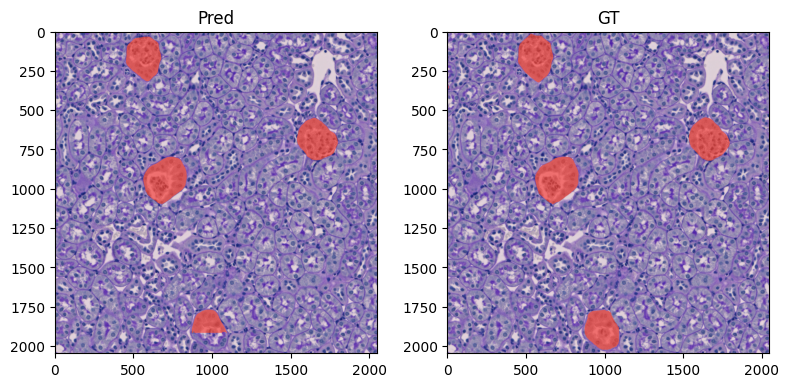

In [7]:
# plot comparison
overlay_pred = overlay(img_data, pred_mask, is_bgr=True)
overlay_gt = overlay(img_data, mask_data, is_bgr=True)

visual_results(img_pred=overlay_pred, img_gt=overlay_gt)